In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [17]:
count_table = pd.read_csv("new_data.csv", sep=";", index_col=0)
pheno_data = pd.read_csv("pheno_data.csv", sep=";", index_col=0)

In [18]:
print(count_table.head())
print(pheno_data.head())

                          CTR1_24h  CTR2_24h  CTR3_24h  CTR4_24h  EV1_24h  \
ENSG00000288531                  0         3         0         0        0   
ENSG00000230368|FAM41C           3         6         2         4        3   
ENSG00000234711|TUBB8P11         0         0         0         0        0   
ENSG00000283040                  0         0         0         0        0   
ENSG00000188290|HES4            25        42        33        20       17   

                          EV2_24h  EV3_24h  EV4_24h  
ENSG00000288531                 0        0        0  
ENSG00000230368|FAM41C          4        2        5  
ENSG00000234711|TUBB8P11        0        0        0  
ENSG00000283040                 0        0        0  
ENSG00000188290|HES4           39       24       47  
            sample condition
CTR1_24h  CTR1_24h       CTR
CTR2_24h  CTR2_24h       CTR
CTR3_24h  CTR3_24h       CTR
CTR4_24h  CTR4_24h       CTR
EV1_24h    EV1_24h        EV


In [19]:
count_table = count_table.T
pheno_data = pheno_data.loc[count_table.index]
count_log = np.log1p(count_table)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(count_log)
percentVar = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=count_table.index)
pca_df["condition"] = pheno_data["condition"].values

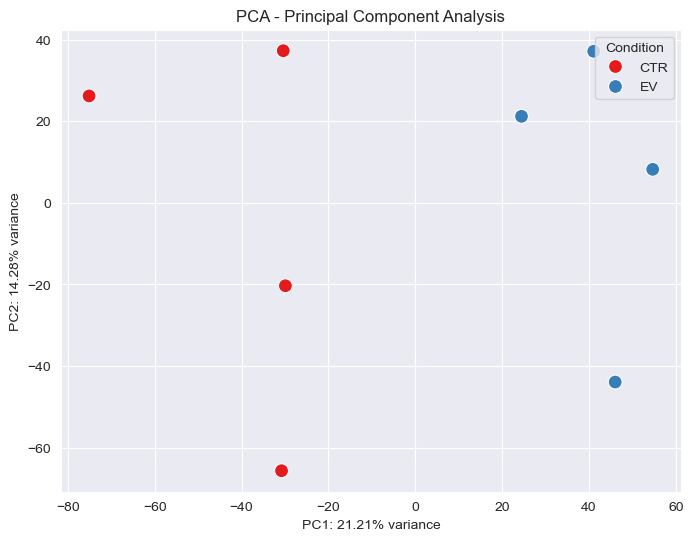

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="condition", s=100, palette="Set1")
plt.xlabel(f"PC1: {percentVar[0]:.2f}% variance")
plt.ylabel(f"PC2: {percentVar[1]:.2f}% variance")
plt.title("PCA - Principal Component Analysis")
plt.legend(title="Condition")
plt.show()

## Punkt 2

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

C:\Users\vex0o\miniconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x600 with 0 Axes>

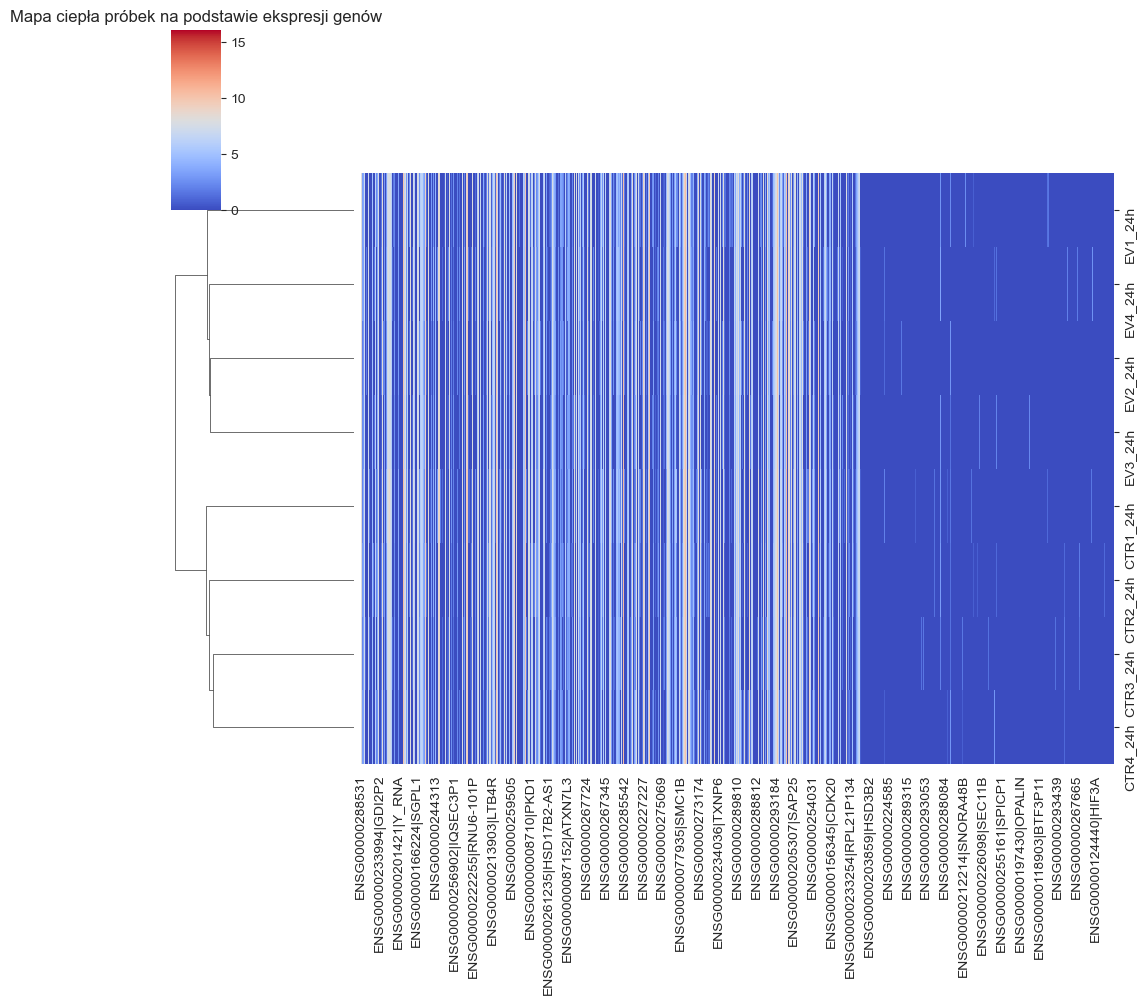

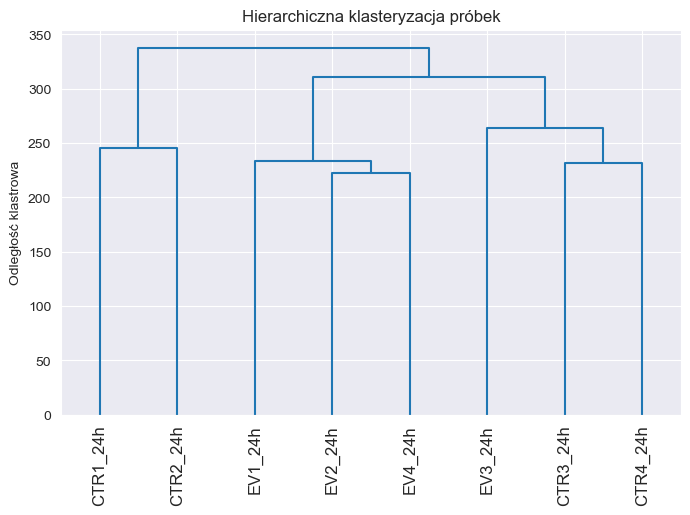

In [27]:
scaler = StandardScaler()
count_scaled = scaler.fit_transform(count_log)

distance_matrix = pdist(count_scaled, metric="euclidean")  # Odległość euklidesowa
linkage_matrix = linkage(distance_matrix, method="ward")  # Metoda Ward’a

plt.figure(figsize=(10, 6))
sns.clustermap(count_log, method="ward", cmap="coolwarm", row_cluster=True, col_cluster=False)
plt.title("Mapa ciepła próbek na podstawie ekspresji genów")
plt.show()

# **Drzewo klasteryzacji**
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, labels=count_log.index, leaf_rotation=90, color_threshold=0.5*max(linkage_matrix[:,2]))
plt.title("Hierarchiczna klasteryzacja próbek")
plt.ylabel("Odległość klastrowa")
plt.show()

In [31]:
de_results = pd.read_csv("differential_expression_results.csv", index_col=0)
print(de_results.head())

de_results['-log10(padj)'] = -np.log10(de_results['padj'])

# Kolorowanie punktów: czerwona dla genów istotnych, czarna dla reszty
de_results['color'] = np.where(de_results['padj'] < 0.001, 'red', 'black')

                           baseMean  log2FoldChange     lfcSE      stat  \
ENSG00000230368|FAM41C     3.559051       -0.058512  0.935919 -0.062519   
ENSG00000188290|HES4      30.338049        0.130705  0.386469  0.338204   
ENSG00000187608|ISG15    379.851664        0.069571  0.138140  0.503628   
ENSG00000187583|PLEKHN1   43.919219       -0.231546  0.390067 -0.593607   
ENSG00000187642|PERM1      7.706554       -0.321302  0.911873 -0.352354   

                           pvalue      padj  
ENSG00000230368|FAM41C   0.950150  0.975114  
ENSG00000188290|HES4     0.735210  0.852827  
ENSG00000187608|ISG15    0.614523  0.773456  
ENSG00000187583|PLEKHN1  0.552775  0.727018  
ENSG00000187642|PERM1    0.724573  0.845951  


## Zadanie 3

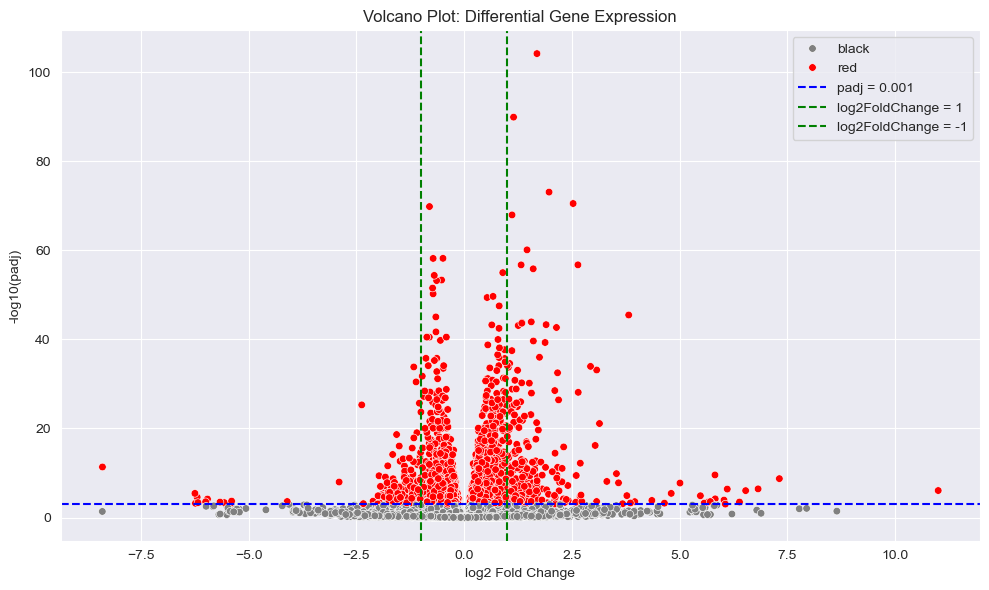

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='log2FoldChange', y='-log10(padj)', data=de_results, hue='color', palette={'red': 'red', 'black': 'gray'}, s=30)
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(padj)')
plt.title('Volcano Plot: Differential Gene Expression')

plt.axhline(y=-np.log10(0.001), color='blue', linestyle='--', label="padj = 0.001")
plt.axvline(x=1, color='green', linestyle='--', label="log2FoldChange = 1")
plt.axvline(x=-1, color='green', linestyle='--', label="log2FoldChange = -1")

plt.legend()

plt.tight_layout()
plt.show()

## Zadanie 4

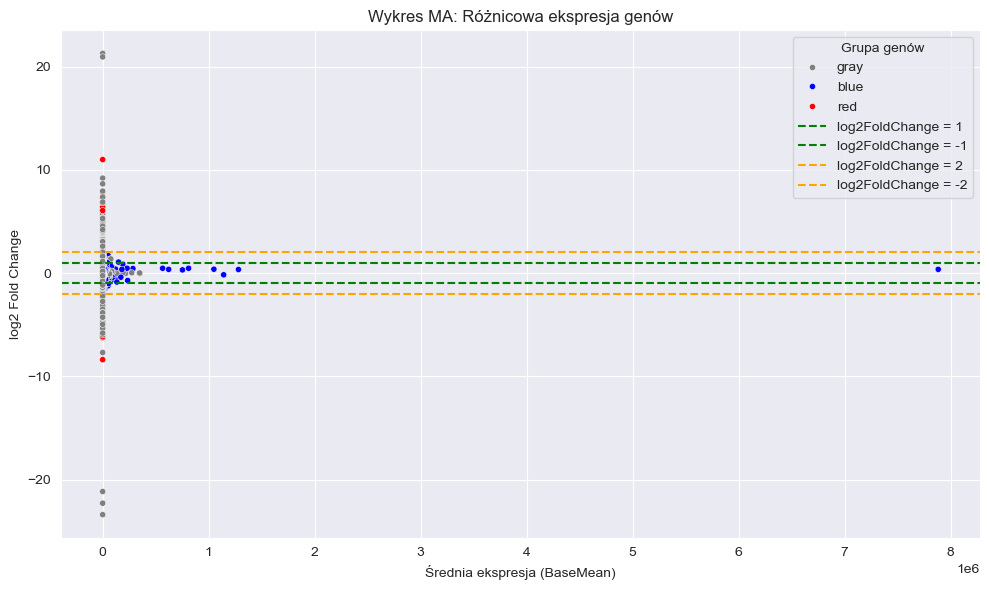

In [35]:
mean_expression = de_results[['baseMean']]

ma_plot_data = pd.DataFrame({
    'mean_expression': mean_expression['baseMean'],
    'log2FoldChange': de_results['log2FoldChange'],
    'padj': de_results['padj']
})

ma_plot_data['color'] = np.where((ma_plot_data['padj'] < 0.001) & (abs(ma_plot_data['log2FoldChange']) > 2), 'red',
                                 np.where((ma_plot_data['padj'] < 0.001), 'blue', 'gray'))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_expression', y='log2FoldChange', data=ma_plot_data, hue='color', palette={'red': 'red', 'blue': 'blue', 'gray': 'gray'}, s=20)

plt.axhline(y=1, color='green', linestyle='--', label="log2FoldChange = 1")
plt.axhline(y=-1, color='green', linestyle='--', label="log2FoldChange = -1")
plt.axhline(y=2, color='orange', linestyle='--', label="log2FoldChange = 2")
plt.axhline(y=-2, color='orange', linestyle='--', label="log2FoldChange = -2")

plt.xlabel('Średnia ekspresja (BaseMean)')
plt.ylabel('log2 Fold Change')
plt.title('Wykres MA: Różnicowa ekspresja genów')
plt.legend(title="Grupa genów", loc='upper right')

plt.tight_layout()
plt.show()

## Zadanie 5

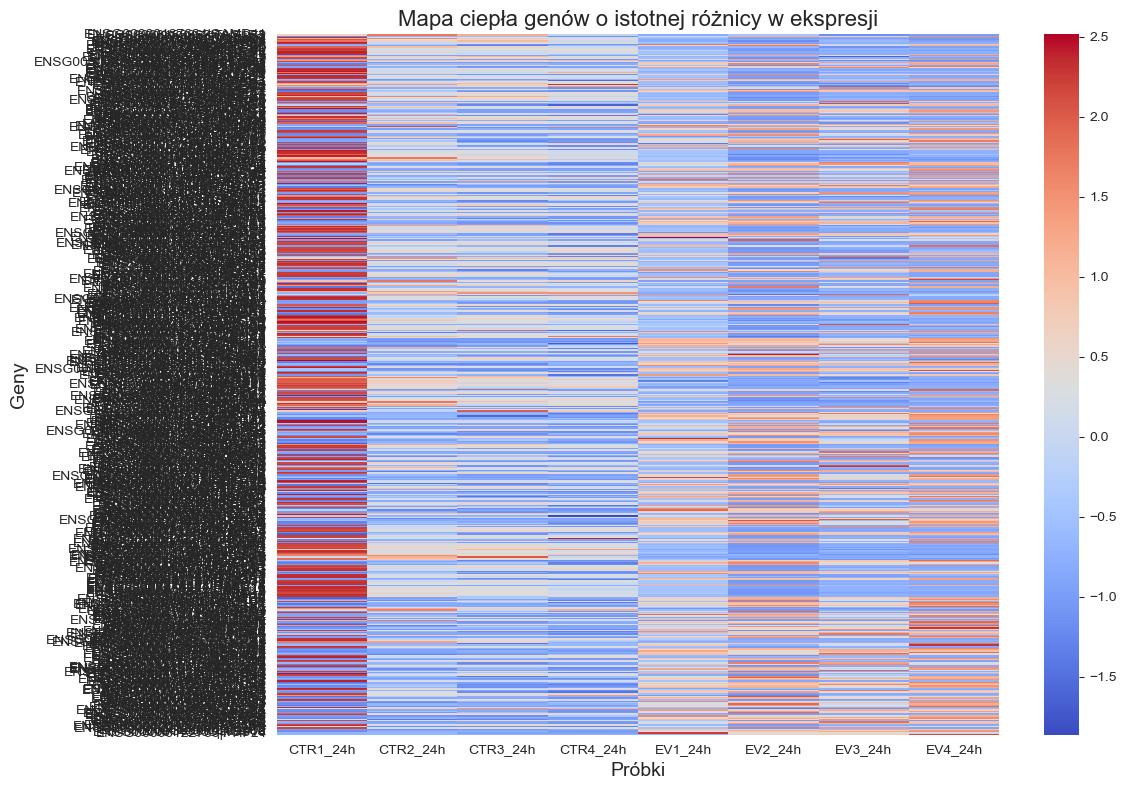

In [38]:
# Wczytanie wyników z analizy różnicowej ekspresji (plik CSV)
de_results = pd.read_csv("differential_expression_results.csv", index_col=0)

# Filtracja genów o istotnej różnicy w ekspresji
# Geny, które mają padj < 0.001 oraz |log2FoldChange| > 1
significant_genes = de_results[(de_results['padj'] < 0.001) & (abs(de_results['log2FoldChange']) > 1)]

# Przygotowanie danych ekspresji genów do wizualizacji
# Wczytujemy count_table (zakładając, że to znormalizowane dane z rlog lub TPM/FPKM)
count_table = pd.read_csv("new_data.csv", sep=";", index_col=0)

# Zastosowanie filtracji, żeby zostawić tylko geny, które są istotne
filtered_data = count_table.loc[significant_genes.index]

# Znormalizowanie danych - standaryzacja, aby każda próbka miała średnią 0 i odchylenie standardowe 1
scaler = StandardScaler()
normalized_data = scaler.fit_transform(filtered_data.T).T

# Stworzenie mapy ciepłej
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_data, cmap="coolwarm", annot=False, fmt=".2f", xticklabels=count_table.columns, yticklabels=filtered_data.index)

# Dodanie tytułu i etykiet
plt.title("Mapa ciepła genów o istotnej różnicy w ekspresji", fontsize=16)
plt.xlabel("Próbki", fontsize=14)
plt.ylabel("Geny", fontsize=14)

# Pokaż wykres
plt.tight_layout()
plt.show()